<div align="center">

# MEGR7172/8172

### Computational Methods (Fall 2025)
### Duke 227, Tu/Th 08:30 - 09:45 pm

</div>


# 16 Implicit Scheme

The **explicit FTCS scheme** we studied has a major limitation: the stability constraint $r \leq 0.5$ severely restricts the time step size. For problems requiring long-time integration or when we want larger time steps, **implicit schemes** provide a powerful alternative.



## 16.1 Backward Euler Scheme

Instead of using the spatial derivative at the current time level $j$, we evaluate it at the future time level $j+1$:

$$\frac{u_j^{n+1} - u_j^n}{\Delta t} = \alpha \frac{u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1}}{(\Delta x)^2}$$

Rearranging with the same parameter $r = \frac{\alpha \Delta t}{(\Delta x)^2}$:

$$u_j^{n+1} - r(u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1}) = u_j^n$$

$$-r u_{j-1}^{n+1} + (1 + 2r) u_j^{n+1} - r u_{j+1}^{n+1} = u_j^n$$

## 16.2 Matrix Formulation

For interior points $j = 1, 2, \ldots, N-1$ with boundary conditions 
$$
u_0^{n+1} = u_N^{n+1} = 0,
$$ 
this gives us a **tridiagonal linear system**:

$$\mathbf{A} \mathbf{u}^{n+1} = \mathbf{u}^n$$

where $\mathbf{A}$ is the tridiagonal matrix:

$$\mathbf{A} = \begin{pmatrix}
1+2r & -r & 0 & 0 & \cdots \\
-r & 1+2r & -r & 0 & \cdots \\
0 & -r & 1+2r & -r & \cdots \\
\vdots & \vdots & \ddots & \ddots & \ddots \\
\cdots & 0 & -r & 1+2r & -r \\
\cdots & 0 & 0 & -r & 1+2r
\end{pmatrix}$$



### 16.3 Stability Analysis

Performing von Neumann analysis on the implicit scheme:

For a Fourier mode $u_j^n = G^n e^{ikj\Delta x}$, substituting into the implicit scheme:

$$G e^{ikj\Delta x} - r G(e^{ik(j+1)\Delta x} - 2e^{ikj\Delta x} + e^{ik(j-1)\Delta x}) = e^{ikj\Delta x}$$

Following similar steps as the explicit case:

$$G[1 - r(e^{ik\Delta x} + e^{-ik\Delta x} - 2)] = 1$$

$$G[1 + 4r\sin^2(k\Delta x/2)] = 1$$

Therefore, the amplification factor is:

$$G = \frac{1}{1 + 4r\sin^2(k\Delta x/2)}$$

**Key observations:**
- Since $r > 0$ and $\sin^2 \geq 0$, we always have $0 < G \leq 1$
- The scheme is **unconditionally stable** for any $r > 0$
- High-frequency modes are strongly damped (which is physically correct for diffusion)


Explicit scheme: r = 0.4, dt = 0.016000
Implicit scheme: r = 3.0, dt = 0.120000
Time step ratio: 7.5


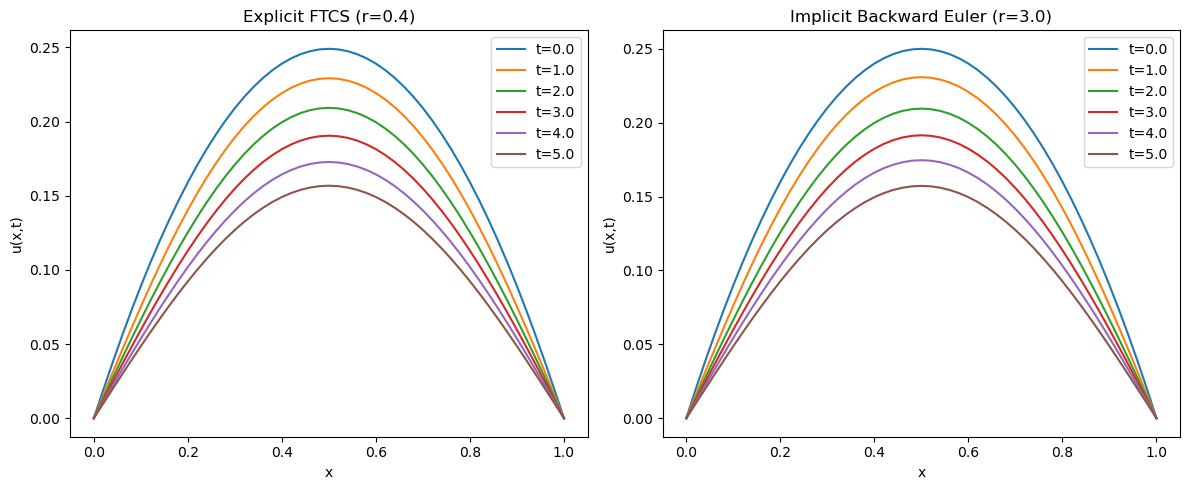

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def solve_heat_explicit(L, alpha, t_max, Nx, r, time_plots=[0.0, 1.0, 5.0]):
    """Helper function for explicit scheme comparison"""
    dx = L / Nx
    dt = r * dx * dx / alpha
    Nt = int(t_max / dt)
    x = np.linspace(0, L, Nx + 1)
    u = x * (1 - x)
    
    snapshots = {0: u.copy()}
    
    for n in range(Nt):
        u_new = u.copy()
        u_new[1:-1] = u[1:-1] + r * (u[2:] - 2*u[1:-1] + u[:-2])
        u_new[0] = 0.0
        u_new[-1] = 0.0
        u = u_new
        
        current_time = (n + 1) * dt
        if abs(current_time - 1.0) < dt/2:
            snapshots[1.0] = u.copy()
        elif abs(current_time - 5.0) < dt/2:
            snapshots[5.0] = u.copy()

        # Store snapshots
        current_time = round((n + 1) * dt, 1)
        if current_time in time_plots:
            snapshots[current_time] = u.copy()
    
    return x, snapshots, dt

def solve_heat_implicit(L, alpha, t_max, Nx, r, time_plots=[0.0, 1.0, 5.0]):
    """
    Solve 1D heat equation using backward Euler (implicit) scheme
    """
    # Grid setup
    dx = L / Nx
    dt = r * dx * dx / alpha
    Nt = int(t_max / dt)
    x = np.linspace(0, L, Nx + 1)
    
    # Initial condition
    u = x * (1 - x)  # u(0) = u(L) = 0
    
    # Build tridiagonal matrix A for implicit scheme
    # Interior points: -r*u[j-1] + (1+2r)*u[j] - r*u[j+1] = u_old[j]
    main_diag = (1 + 2*r) * np.ones(Nx - 1)
    off_diag = -r * np.ones(Nx - 2)
    
    A = diags([off_diag, main_diag, off_diag], 
              offsets=[-1, 0, 1], 
              shape=(Nx-1, Nx-1), 
              format='csr')
    
    # Storage for snapshots
    snapshots = {0: u.copy()}
    
    # Time stepping
    for n in range(Nt):
        # Right-hand side (known values at current time)
        rhs = u[1:-1].copy()  # Interior points only
        
        # Solve linear system A * u_new[1:-1] = rhs
        u_interior = spsolve(A, rhs)
        
        # Update solution (boundaries remain zero)
        u[1:-1] = u_interior
        u[0] = 0.0
        u[-1] = 0.0
        
        # Store snapshots
        current_time = round((n + 1) * dt, 1)
        if current_time in time_plots:
            snapshots[current_time] = u.copy()
    
    return x, snapshots, dt

# Compare explicit vs implicit schemes
L = 1.0
alpha = 0.01
t_max = 6.0
Nx = 50

time_plots = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
# Explicit scheme (r = 0.4 for stability)
r_explicit = 0.4
x_exp, snap_exp, dt_exp = solve_heat_explicit(L, alpha, t_max, Nx, r_explicit, time_plots)

# Implicit scheme (r = 1.0, much larger time step!)
r_implicit = 3.0
x_imp, snap_imp, dt_imp = solve_heat_implicit(L, alpha, t_max, Nx, r_implicit, time_plots)

print(f"Explicit scheme: r = {r_explicit}, dt = {dt_exp:.6f}")
print(f"Implicit scheme: r = {r_implicit}, dt = {dt_imp:.6f}")
print(f"Time step ratio: {dt_imp/dt_exp:.1f}")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Explicit results
for t in time_plots:
    ax1.plot(x_exp, snap_exp[t], label=f't={t}')
ax1.set_title(f'Explicit FTCS (r={r_explicit})')
ax1.set_xlabel('x')
ax1.set_ylabel('u(x,t)')
ax1.legend()

# Implicit results
for t in time_plots:
    ax2.plot(x_imp, snap_imp[t], label=f't={t}')
ax2.set_title(f'Implicit Backward Euler (r={r_implicit})')
ax2.set_xlabel('x')
ax2.set_ylabel('u(x,t)')
ax2.legend()

plt.tight_layout()
plt.show()




### 16.4 Advantages and Disadvantages

**Advantages:**
1. **Unconditional stability**: No restriction on time step size
2. **Larger time steps**: Can use $\Delta t$ much larger than explicit schemes
3. **Better for stiff problems**: Handles rapid transients well
4. **Long-time integration**: Efficient for problems requiring $t \gg (\Delta x)^2/\alpha$

**Disadvantages:**
1. **Computational cost**: Must solve linear system at each time step
2. **Memory requirements**: Need to store and factor tridiagonal matrix
3. **Accuracy**: Still only first-order accurate in time $O(\Delta t)$
4. **Over-damping**: May excessively damp high-frequency components



### 16.5 Crank-Nicolson Scheme (Semi-Implicit)

A popular compromise is the **Crank-Nicolson scheme**, which averages explicit and implicit approaches:

$$\frac{u_j^{n+1} - u_j^n}{\Delta t} = \frac{\alpha}{2}\left[\frac{u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1}}{(\Delta x)^2} + \frac{u_{j+1}^n - 2u_j^n + u_{j-1}^n}{(\Delta x)^2}\right]$$

This can be written as:

$$-\frac{r}{2}u_{j-1}^{n+1} + \left(1 + r\right)u_j^{n+1} - \frac{r}{2}u_{j+1}^{n+1} = \frac{r}{2}u_{j-1}^n + \left(1 - r\right)u_j^n + \frac{r}{2}u_{j+1}^n$$

**Advantages of Crank-Nicolson:**
- **Second-order accurate** in time: $O((\Delta t)^2)$
- **Unconditionally stable**
- **Less dissipative** than backward Euler
- **Widely used** in practice


The Crank-Nicolson scheme requires solving a linear system at each time step:

$$\mathbf{A}_{LHS} \mathbf{u}^{n+1} = \mathbf{A}_{RHS} \mathbf{u}^n$$

where:
- **Left-hand side matrix** $\mathbf{A}_{LHS}$: Contains the implicit terms with coefficients $(-r/2, 1+r, -r/2)$
- **Right-hand side matrix** $\mathbf{A}_{RHS}$: Contains the explicit terms with coefficients $(r/2, 1-r, r/2)$

**Key advantages demonstrated in the code:**
1. **Higher accuracy**: Second-order in time, compared to first-order for explicit/implicit Euler
2. **Unconditional stability**: Can use larger time steps than explicit methods
3. **Balanced approach**: Less dissipative than pure implicit, more stable than pure explicit

**Performance comparison:**
- The code compares all three methods with different $r$ values
- Includes analytical solution comparison to assess accuracy
- Shows error analysis demonstrating Crank-Nicolson's superior accuracy


Comparing three finite difference schemes for heat equation:
Explicit FTCS:    r = 0.4
Implicit Euler:   r = 2.0
Crank-Nicolson:   r = 1.0
Time steps:
Explicit:      dt = 0.000063
Implicit:      dt = 0.000313
Crank-Nicolson: dt = 0.000156
Time steps:
Explicit:      dt = 0.000063
Implicit:      dt = 0.000313
Crank-Nicolson: dt = 0.000156


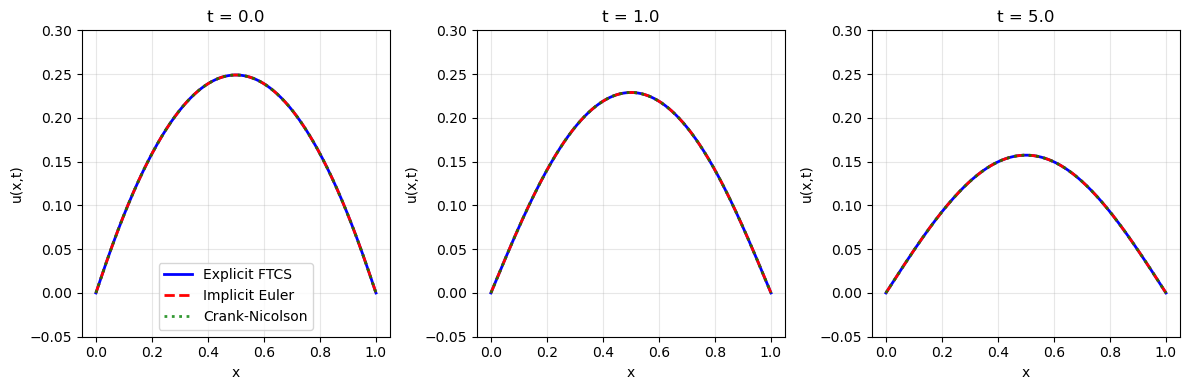

In [64]:
def solve_heat_crank_nicolson(L, alpha, t_max, Nx, r, time_plots=[0.0, 1.0, 5.0]):
    """
    Solve 1D heat equation using Crank-Nicolson (semi-implicit) scheme
    """
    # Grid setup
    dx = L / Nx
    dt = r * dx * dx / alpha
    Nt = int(t_max / dt)
    x = np.linspace(0, L, Nx + 1)
    
    # Initial condition
    u = x * (1 - x)  # u(0) = u(L) = 0
    
    # Build matrices for Crank-Nicolson scheme
    # Left side: (-r/2)*u[j-1] + (1+r)*u[j] + (-r/2)*u[j+1] = RHS
    # Right side: (r/2)*u[j-1] + (1-r)*u[j] + (r/2)*u[j+1]
    
    # Left-hand side matrix (implicit part)
    main_diag_lhs = (1 + r) * np.ones(Nx - 1)
    off_diag_lhs = (-r/2) * np.ones(Nx - 2)
    
    A_lhs = diags([off_diag_lhs, main_diag_lhs, off_diag_lhs], 
                  offsets=[-1, 0, 1], 
                  shape=(Nx-1, Nx-1), 
                  format='csr')
    
    # Right-hand side matrix (explicit part)
    main_diag_rhs = (1 - r) * np.ones(Nx - 1)
    off_diag_rhs = (r/2) * np.ones(Nx - 2)
    
    A_rhs = diags([off_diag_rhs, main_diag_rhs, off_diag_rhs], 
                  offsets=[-1, 0, 1], 
                  shape=(Nx-1, Nx-1), 
                  format='csr')
    
    # Storage for snapshots
    snapshots = {0: u.copy()}
    
    # Time stepping
    for n in range(Nt):
        # Right-hand side: A_rhs * u_current[interior]
        rhs = A_rhs.dot(u[1:-1])
        
        # Solve linear system: A_lhs * u_new[interior] = rhs
        u_interior = spsolve(A_lhs, rhs)
        
        # Update solution (boundaries remain zero)
        u[1:-1] = u_interior
        u[0] = 0.0
        u[-1] = 0.0
        
        # Store snapshots
        current_time = round((n + 1) * dt, 1)
        if current_time in time_plots:
            snapshots[current_time] = u.copy()
    
    return x, snapshots, dt

# Compare all three schemes: Explicit, Implicit, and Crank-Nicolson
L = 1.0
alpha = 0.01
t_max = 5.0
Nx = 800
time_plots = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

# Different r values to showcase stability properties
r_explicit = 0.4      # Must be ≤ 0.5 for stability
r_implicit = 2.0      # Can be much larger
r_crank = 1.0         # Unconditionally stable, good accuracy

print("Comparing three finite difference schemes for heat equation:")
print(f"Explicit FTCS:    r = {r_explicit}")
print(f"Implicit Euler:   r = {r_implicit}")
print(f"Crank-Nicolson:   r = {r_crank}")

# Solve with all three methods
x_exp, snap_exp, dt_exp = solve_heat_explicit(L, alpha, t_max, Nx, r_explicit, time_plots)
x_imp, snap_imp, dt_imp = solve_heat_implicit(L, alpha, t_max, Nx, r_implicit, time_plots)
x_cn, snap_cn, dt_cn = solve_heat_crank_nicolson(L, alpha, t_max, Nx, r_crank, time_plots)

print(f"Time steps:")
print(f"Explicit:      dt = {dt_exp:.6f}")
print(f"Implicit:      dt = {dt_imp:.6f}")
print(f"Crank-Nicolson: dt = {dt_cn:.6f}")

# Plot comparison at different times
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

plot_times = [0.0, 1.0, 5.0]

for i, t in enumerate(plot_times):
    ax = axes[i]
    
    # Plot all three solutions at time t
    if t in snap_exp:
        ax.plot(x_exp, snap_exp[t], 'b-', label='Explicit FTCS', linewidth=2)
    if t in snap_imp:
        ax.plot(x_imp, snap_imp[t], 'r--', label='Implicit Euler', linewidth=2)
    if t in snap_cn:
        ax.plot(x_cn, snap_cn[t], 'g:', label='Crank-Nicolson', linewidth=2, alpha=0.8)
    
    ax.set_title(f't = {t}')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.set_ylim(-0.05, 0.3)
    ax.grid(True, alpha=0.3)
    
    if i == 0:  ax.legend()

plt.tight_layout()
plt.show()

CONVERGENCE STUDY - Error vs. Time Step Size
Spatial grid: Nx = 800, dx = 0.001250
Comparison time: t = 1.0
Time step range: dt = 7.81e-06 to 7.81e-05
r      dt           Explicit     Implicit     Crank-Nicolson 
0.05   7.81e-06     7.28e-07     1.35e-06     1.04e-06       
0.05   7.81e-06     7.28e-07     1.35e-06     1.04e-06       
0.10   1.56e-05     4.16e-07     1.66e-06     1.04e-06       
0.10   1.56e-05     4.16e-07     1.66e-06     1.04e-06       
0.20   3.13e-05     2.08e-07     2.29e-06     1.04e-06       
0.20   3.13e-05     2.08e-07     2.29e-06     1.04e-06       
0.25   3.91e-05     5.20e-07     2.60e-06     1.04e-06       
0.25   3.91e-05     5.20e-07     2.60e-06     1.04e-06       
0.40   6.25e-05     1.46e-06     3.54e-06     1.04e-06       
0.40   6.25e-05     1.46e-06     3.54e-06     1.04e-06       
0.50   7.81e-05     2.08e-06     4.16e-06     1.04e-06       
0.50   7.81e-05     2.08e-06     4.16e-06     1.04e-06       


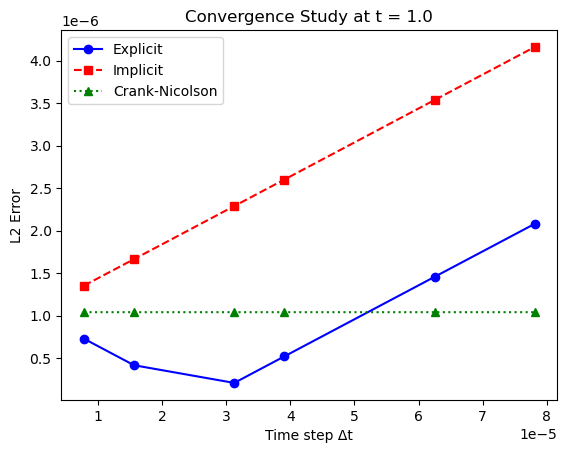

In [80]:
# Analyze accuracy: compare with analytical solution at t = 1.0
def analytical_solution(x, t, alpha, n_terms=50):
    """
    Analytical solution for heat equation with initial condition u(x,0) = x(1-x)
    Using separation of variables: u(x,t) = sum of A_n * sin(n*pi*x) * exp(-n^2*pi^2*alpha*t)
    """
    u_analytical = np.zeros_like(x)
    for n in range(1, n_terms + 1):
        # Fourier coefficient for u(x,0) = x(1-x)
        if n % 2 == 1:  # odd n
            A_n = 8 / (n**3 * np.pi**3)
            u_analytical += A_n * np.sin(n * np.pi * x) * np.exp(-n**2 * np.pi**2 * alpha * t)
    return u_analytical

# Convergence study: error as a function of dt for each method
print("CONVERGENCE STUDY - Error vs. Time Step Size")

# Parameters for convergence study
L = 1.0
alpha = 0.01
t_compare = 1.0  # Time at which to compare errors
Nx_conv = 800    # Fine enough spatial grid to isolate temporal errors

# Range of r values (and corresponding dt values)
r_values_conv = np.array([0.05, 0.1, 0.2, 0.25, 0.4, 0.5])
dx_conv = L / Nx_conv
dt_values_conv = r_values_conv * (dx_conv**2) / alpha

# Storage for errors
errors_exp_conv = []
errors_imp_conv = []
errors_cn_conv = []

print(f"Spatial grid: Nx = {Nx_conv}, dx = {dx_conv:.6f}")
print(f"Comparison time: t = {t_compare}")
print(f"Time step range: dt = {dt_values_conv[0]:.2e} to {dt_values_conv[-1]:.2e}")
print(f"{'r':<6} {'dt':<12} {'Explicit':<12} {'Implicit':<12} {'Crank-Nicolson':<15}")

# Compute errors for each r value
for r_val in r_values_conv:
    dt_val = r_val * (dx_conv**2) / alpha
    
    # Only compute explicit if stable (r <= 0.5)
    x_exp, snap_exp, _ = solve_heat_explicit(L, alpha, t_compare, Nx_conv, r_val, [t_compare])
    u_analytical = analytical_solution(x_exp, t_compare, alpha)
        
    # Find closest time in snapshots
    actual_time_exp = min(snap_exp.keys(), key=lambda x: abs(x - t_compare))
    error_exp = np.linalg.norm(snap_exp[actual_time_exp] - u_analytical)
    errors_exp_conv.append(error_exp)
    exp_str = f"{error_exp:.2e}"
    
    # Implicit method (always stable)
    x_imp, snap_imp, _ = solve_heat_implicit(L, alpha, t_compare, Nx_conv, r_val, [t_compare])
    u_analytical = analytical_solution(x_imp, t_compare, alpha)
    actual_time_imp = min(snap_imp.keys(), key=lambda x: abs(x - t_compare))
    error_imp = np.linalg.norm(snap_imp[actual_time_imp] - u_analytical)
    errors_imp_conv.append(error_imp)
    
    # Crank-Nicolson method (always stable)
    x_cn, snap_cn, _ = solve_heat_crank_nicolson(L, alpha, t_compare, Nx_conv, r_val, [t_compare])
    u_analytical = analytical_solution(x_cn, t_compare, alpha)
    actual_time_cn = min(snap_cn.keys(), key=lambda x: abs(x - t_compare))
    error_cn = np.linalg.norm(snap_cn[actual_time_cn] - u_analytical)
    errors_cn_conv.append(error_cn)
    
    print(f"{r_val:<6.2f} {dt_val:<12.2e} {exp_str:<12} {error_imp:<12.2e} {error_cn:<15.2e}")

# Convert to arrays for analysis
errors_exp_conv = np.array(errors_exp_conv)
errors_imp_conv = np.array(errors_imp_conv)
errors_cn_conv = np.array(errors_cn_conv)

# Plot results
plt.plot(dt_values_conv, errors_exp_conv, 'bo-', label='Explicit')
plt.plot(dt_values_conv, errors_imp_conv, 'rs--', label='Implicit')
plt.plot(dt_values_conv, errors_cn_conv, 'g^:', label='Crank-Nicolson')

plt.xlabel('Time step Δt')
plt.ylabel('L2 Error')
plt.title(f'Convergence Study at t = {t_compare}')
plt.legend()
plt.show()